In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import logging
import traceback
from flask import Flask, request, jsonify
from werkzeug.exceptions import BadRequest
import os
import joblib
import warnings
import io
import sys
import time
import base64
from typing import List, Dict, Any, Optional

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load the dataset
admissions = pd.read_csv("/Users/yashikasharma/Downloads/admissions.csv")
fatalities = pd.read_csv("/Users/yashikasharma/Downloads/fatalities.csv")
metrics = pd.read_csv("/Users/yashikasharma/Downloads/metrics.csv")
prescriptions = pd.read_csv("/Users/yashikasharma/Downloads/prescriptions.csv")
smokers = pd.read_csv("/Users/yashikasharma/Downloads/smokers.csv")

Data Preprocessing

In [3]:
# ---------- Helper Function ----------
def extract_year(x):
    """Extracts a 4-digit year (e.g., '2014/15' -> 2014)."""
    if pd.isna(x):
        return np.nan
    x = str(x)
    if "/" in x:
        return int(x.split("/")[0])
    try:
        return int(x[:4])
    except:
        try:
            return int(float(x))
        except:
            return np.nan

In [4]:
# ---------- Admissions ----------
ad = admissions.copy()
ad["Year"] = ad["Year"].apply(extract_year)
ad["Value"] = pd.to_numeric(ad["Value"].astype(str).str.replace(",", "").str.strip(), errors="coerce")
ad["Sex"] = ad["Sex"].fillna("All")
for c in ad.select_dtypes(include="object").columns:
    ad[c] = ad[c].str.strip()
ad.rename(columns={'Value': 'Admissions'}, inplace=True)
ad.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Admissions
0,2014,All codes,All admissions,All admissions,Number of admissions,All,11011882.0
1,2014,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All diseases which can be caused by smoking,All diseases which can be caused by smoking,Number of admissions,All,1713330.0
2,2014,C00-D48,All cancers,All cancers,Number of admissions,All,1691035.0
3,2014,J00-J99,All respiratory diseases,All respiratory diseases,Number of admissions,All,611002.0
4,2014,I00-I99,All circulatory diseases,All circulatory diseases,Number of admissions,All,907157.0


In [5]:
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             2079 non-null   int64  
 1   ICD10 Code       2079 non-null   object 
 2   ICD10 Diagnosis  2079 non-null   object 
 3   Diagnosis Type   2079 non-null   object 
 4   Metric           2079 non-null   object 
 5   Sex              2079 non-null   object 
 6   Admissions       2038 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 113.8+ KB


In [6]:
ad.isnull().sum()

Year                0
ICD10 Code          0
ICD10 Diagnosis     0
Diagnosis Type      0
Metric              0
Sex                 0
Admissions         41
dtype: int64

In [7]:
# ---------- Fatalities ----------
ft = fatalities.copy()
ft["Year"] = ft["Year"].apply(extract_year)
ft["Value"] = pd.to_numeric(ft["Value"].astype(str).str.replace(",", "").str.strip(), errors="coerce")
ft["Sex"] = ft["Sex"].fillna("All")
for c in ft.select_dtypes(include="object").columns:
    ft[c] = ft[c].str.strip()
ft.rename(columns={'Value': 'Fatalities'}, inplace=True)
ft.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Fatalities
0,2014,All codes,All deaths,All deaths,Number of observed deaths,All,459087.0
1,2014,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,All,235820.0
2,2014,C00-D48,All cancers,All cancers,Number of observed deaths,All,136312.0
3,2014,J00-J99,All respiratory diseases,All respiratory diseases,Number of observed deaths,All,61744.0
4,2014,I00-I99,All circulatory diseases,All circulatory diseases,Number of observed deaths,All,126101.0


In [8]:
ft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             1749 non-null   int64  
 1   ICD10 Code       1749 non-null   object 
 2   ICD10 Diagnosis  1749 non-null   object 
 3   Diagnosis Type   1749 non-null   object 
 4   Metric           1749 non-null   object 
 5   Sex              1749 non-null   object 
 6   Fatalities       1729 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 95.8+ KB


In [9]:
ft.isnull().sum()

Year                0
ICD10 Code          0
ICD10 Diagnosis     0
Diagnosis Type      0
Metric              0
Sex                 0
Fatalities         20
dtype: int64

In [10]:
# ---------- Metrics ----------
mt = metrics.copy()
mt.columns = [c.replace("\n", " ").strip() for c in mt.columns]
for c in mt.columns:
    if c.lower() != "year":
        mt[c] = pd.to_numeric(mt[c].astype(str).str.replace(",", "").str.strip(), errors="coerce")

if mt["Year"].dtype == object:
    mt["Year"] = mt["Year"].apply(extract_year)

mt_numeric = mt.select_dtypes(include=[np.number])
mt[mt_numeric.columns] = mt_numeric.interpolate(method="linear", limit_direction="both").fillna(mt_numeric.median())
mt.head()

,Year,Tobacco Price Index,Retail Prices Index,Tobacco Price Index Relative to Retail Price Index,Real Households' Disposable Income,Affordability of Tobacco Index,Household Expenditure on Tobacco,Household Expenditure Total,Expenditure on Tobacco as a Percentage of Expenditure
0,2015,1294.3,386.7,334.7,196.4,58.7,19252.0,1152387.0,1.7
1,2014,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7
2,2013,1139.3,374.2,304.5,190.3,62.5,18683.0,1073106.0,1.7
3,2012,1057.8,363.1,291.3,192.9,66.2,18702.0,1029378.0,1.8
4,2011,974.9,351.9,277.1,189.3,68.3,18217.0,990828.0,1.8


In [11]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Year                                                   36 non-null     int64  
 1   Tobacco Price Index                                    36 non-null     float64
 2   Retail Prices Index                                    36 non-null     float64
 3   Tobacco Price Index Relative to Retail Price Index     36 non-null     float64
 4   Real Households' Disposable Income                     36 non-null     float64
 5   Affordability of Tobacco Index                         36 non-null     float64
 6   Household Expenditure on Tobacco                       36 non-null     float64
 7   Household Expenditure Total                            36 non-null     float64
 8   Expenditure on Tobacco as a Percentage of Expenditure

In [12]:
mt.isnull().sum()

Year                                                     0
Tobacco Price Index                                      0
Retail Prices Index                                      0
Tobacco Price Index Relative to Retail Price Index       0
Real Households' Disposable Income                       0
Affordability of Tobacco Index                           0
Household Expenditure on Tobacco                         0
Household Expenditure Total                              0
Expenditure on Tobacco as a Percentage of Expenditure    0
dtype: int64

In [13]:
# ---------- Prescriptions ----------
pr = prescriptions.copy()
pr["Year"] = pr["Year"].apply(extract_year)
for c in pr.columns:
    if c.lower() != "year":
        pr[c] = pd.to_numeric(pr[c].astype(str).str.replace(",", "").str.strip(), errors="coerce")
pr = pr.fillna(pr.select_dtypes(include=[np.number]).median())
pr.head()

,Year,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,Bupropion (Zyban) Prescriptions,Varenicline (Champix) Prescriptions,Net Ingredient Cost of All Pharmacotherapies,Net Ingredient Cost of Nicotine Replacement Therapies (NRT),Net Ingredient Cost of Bupropion (Zyban),Net Ingredient Cost of Varenicline (Champix)
0,2014,1348,766,21,561.0,38145,18208,807,19129.0
1,2013,1778,1059,22,697.0,48767,24257,865,23646.0
2,2012,2203,1318,26,859.0,58121,28069,994,29058.0
3,2011,2532,1545,30,957.0,64552,30951,1216,32385.0
4,2010,2564,1541,36,987.0,65883,30808,1581,33494.0


In [14]:
pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 9 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Year                                                         11 non-null     int64  
 1   All Pharmacotherapy Prescriptions                            11 non-null     int64  
 2   Nicotine Replacement Therapy (NRT) Prescriptions             11 non-null     int64  
 3   Bupropion (Zyban) Prescriptions                              11 non-null     int64  
 4   Varenicline (Champix) Prescriptions                          11 non-null     float64
 5   Net Ingredient Cost of All Pharmacotherapies                 11 non-null     int64  
 6   Net Ingredient Cost of Nicotine Replacement Therapies (NRT)  11 non-null     int64  
 7   Net Ingredient Cost of Bupropion (Zyban)                     11 non-null     int64 

In [15]:
pr.isnull().sum()

Year                                                           0
All Pharmacotherapy Prescriptions                              0
Nicotine Replacement Therapy (NRT) Prescriptions               0
Bupropion (Zyban) Prescriptions                                0
Varenicline (Champix) Prescriptions                            0
Net Ingredient Cost of All Pharmacotherapies                   0
Net Ingredient Cost of Nicotine Replacement Therapies (NRT)    0
Net Ingredient Cost of Bupropion (Zyban)                       0
Net Ingredient Cost of Varenicline (Champix)                   0
dtype: int64

In [16]:
# ---------- Smokers ----------
sm = smokers.copy()
sm["Sex"] = sm["Sex"].fillna("All")
age_cols = [c for c in sm.columns if c not in ["Year", "Method", "Sex"]]
for c in age_cols:
    sm[c] = pd.to_numeric(sm[c].astype(str).str.replace(",", "").str.strip(), errors="coerce")
if sm["Year"].dtype == object:
    sm["Year"] = sm["Year"].apply(extract_year)
sm.head()

,Year,Method,Sex,16 and Over,16-24,25-34,35-49,50-59,60 and Over
0,1974,Unweighted,All,46,44,51,52,50,33
1,1976,Unweighted,All,42,42,45,48,48,30
2,1978,Unweighted,All,40,39,45,45,45,30
3,1980,Unweighted,All,39,37,46,44,45,29
4,1982,Unweighted,All,35,35,38,39,41,27


In [17]:
sm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Year         84 non-null     int64 
 1   Method       84 non-null     object
 2   Sex          84 non-null     object
 3   16 and Over  84 non-null     int64 
 4   16-24        84 non-null     int64 
 5   25-34        84 non-null     int64 
 6   35-49        84 non-null     int64 
 7   50-59        84 non-null     int64 
 8   60 and Over  84 non-null     int64 
dtypes: int64(7), object(2)
memory usage: 6.0+ KB


In [18]:
sm.isnull().sum()

Year           0
Method         0
Sex            0
16 and Over    0
16-24          0
25-34          0
35-49          0
50-59          0
60 and Over    0
dtype: int64

In [19]:
# Handle missing values
# -------------------------------------------------
# STEP 1: Convert former Value columns to numeric
# -------------------------------------------------
ad["Admissions"] = pd.to_numeric(ad["Admissions"], errors="coerce")
ft["Fatalities"] = pd.to_numeric(ft["Fatalities"], errors="coerce")

In [20]:
# -------------------------------------------------
# STEP 2: Impute missing 'Value' by group median
#          (based on Year, Sex, Diagnosis Type)
# -------------------------------------------------
ad["Admissions"] = ad.groupby(["Year", "Sex", "Diagnosis Type"])["Admissions"].transform(
    lambda x: x.fillna(x.median())
)

ft["Fatalities"] = ft.groupby(["Year", "Sex", "Diagnosis Type"])["Fatalities"].transform(
    lambda x: x.fillna(x.median())
)
print(ad.isnull().sum())
print(ft.isnull().sum())

Year               0
ICD10 Code         0
ICD10 Diagnosis    0
Diagnosis Type     0
Metric             0
Sex                0
Admissions         0
dtype: int64
Year               0
ICD10 Code         0
ICD10 Diagnosis    0
Diagnosis Type     0
Metric             0
Sex                0
Fatalities         0
dtype: int64


In [21]:
# 1) Create a yearly features table (smokers/prescriptions/metrics aggregated by Year)
sm_year = sm.drop(columns=["Method","Sex"], errors="ignore").groupby("Year", as_index=False).mean()
pr_year = pr.groupby("Year", as_index=False).sum()
mt_year = mt.groupby("Year", as_index=False).mean()

yearly_features = sm_year.merge(pr_year, on="Year", how="outer").merge(mt_year, on="Year", how="outer")

# 2) Attach yearly_features to admissions (broadcast by Year) -> preserves all admission rows
ad_detailed = ad.merge(yearly_features, on="Year", how="left")
# 3) Attach yearly_features to fatalities (preserves all fatality rows)
ft_detailed = ft.merge(yearly_features, on="Year", how="left")

# 4) Optionally concatenate both detailed tables into one large long table
#    This keeps every original row from admissions AND fatalities.
ad_detailed["source_dataset"] = "admissions"
ft_detailed["source_dataset"] = "fatalities"
df = pd.concat([ad_detailed, ft_detailed], axis=0, ignore_index=True, sort=False)

# 5) Impute numeric columns in df (median per column)
num_cols = df.select_dtypes(include="number").columns.tolist()
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
df.describe()

,Year,Admissions,16 and Over,16-24,25-34,35-49,50-59,60 and Over,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,...,Net Ingredient Cost of Varenicline (Champix),Tobacco Price Index,Retail Prices Index,Tobacco Price Index Relative to Retail Price Index,Real Households' Disposable Income,Affordability of Tobacco Index,Household Expenditure on Tobacco,Household Expenditure Total,Expenditure on Tobacco as a Percentage of Expenditure,Fatalities
count,3828.000000,3.828000e+03,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,...,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3.828000e+03,3828.000000,3828.000000
mean,2009.000000,1.082844e+05,21.151515,25.060606,27.030303,24.424242,21.151515,12.757576,2179.454545,1541.636364,...,24018.545455,879.981818,329.063636,264.645455,192.109091,73.390909,16932.727273,9.402448e+05,1.800000,10605.816353
std,3.162691,6.282550e+05,1.743113,2.182945,2.603580,2.211787,1.760416,0.975490,349.169023,370.571690,...,8485.748041,184.540140,33.712166,28.141110,2.448865,7.526147,1479.319642,1.023500e+05,0.085291,36928.783342
min,2004.000000,0.000000e+00,18.666667,22.333333,23.333333,21.000000,19.000000,11.000000,1348.000000,766.000000,...,760.000000,654.600000,279.300000,234.400000,188.700000,59.400000,15300.000000,7.721640e+05,1.700000,0.000000
25%,2006.000000,1.145050e+04,20.000000,23.000000,25.000000,23.000000,19.333333,12.333333,2044.000000,1318.000000,...,21714.000000,713.700000,296.400000,240.800000,190.000000,66.200000,15542.000000,8.514560e+05,1.700000,2687.000000
50%,2009.000000,1.269800e+04,21.000000,25.000000,26.333333,24.000000,21.000000,12.666667,2205.000000,1545.000000,...,24694.000000,815.900000,321.300000,255.200000,192.300000,76.700000,16209.000000,9.282650e+05,1.800000,2687.000000
75%,2012.000000,1.561075e+04,22.000000,26.333333,29.666667,25.333333,22.333333,13.666667,2483.000000,1908.000000,...,29936.000000,1057.800000,363.100000,291.300000,195.000000,80.100000,18683.000000,1.029378e+06,1.800000,2687.000000
max,2014.000000,1.101188e+07,24.666667,29.000000,31.333333,29.333333,24.333333,14.333333,2564.000000,2076.000000,...,33494.000000,1226.000000,383.000000,320.100000,195.900000,80.600000,19411.000000,1.118992e+06,2.000000,469186.000000


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 31 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Year                                                         3828 non-null   int64  
 1   ICD10 Code                                                   3828 non-null   object 
 2   ICD10 Diagnosis                                              3828 non-null   object 
 3   Diagnosis Type                                               3828 non-null   object 
 4   Metric                                                       3828 non-null   object 
 5   Sex                                                          3828 non-null   object 
 6   Admissions                                                   3828 non-null   float64
 7   16 and Over                                                  3828 non-null   f

In [23]:
df.isnull().sum()

Year                                                           0
ICD10 Code                                                     0
ICD10 Diagnosis                                                0
Diagnosis Type                                                 0
Metric                                                         0
Sex                                                            0
Admissions                                                     0
16 and Over                                                    0
16-24                                                          0
25-34                                                          0
35-49                                                          0
50-59                                                          0
60 and Over                                                    0
All Pharmacotherapy Prescriptions                              0
Nicotine Replacement Therapy (NRT) Prescriptions               0
Bupropion (Zyban) Prescri

Exploratory Data Analysis

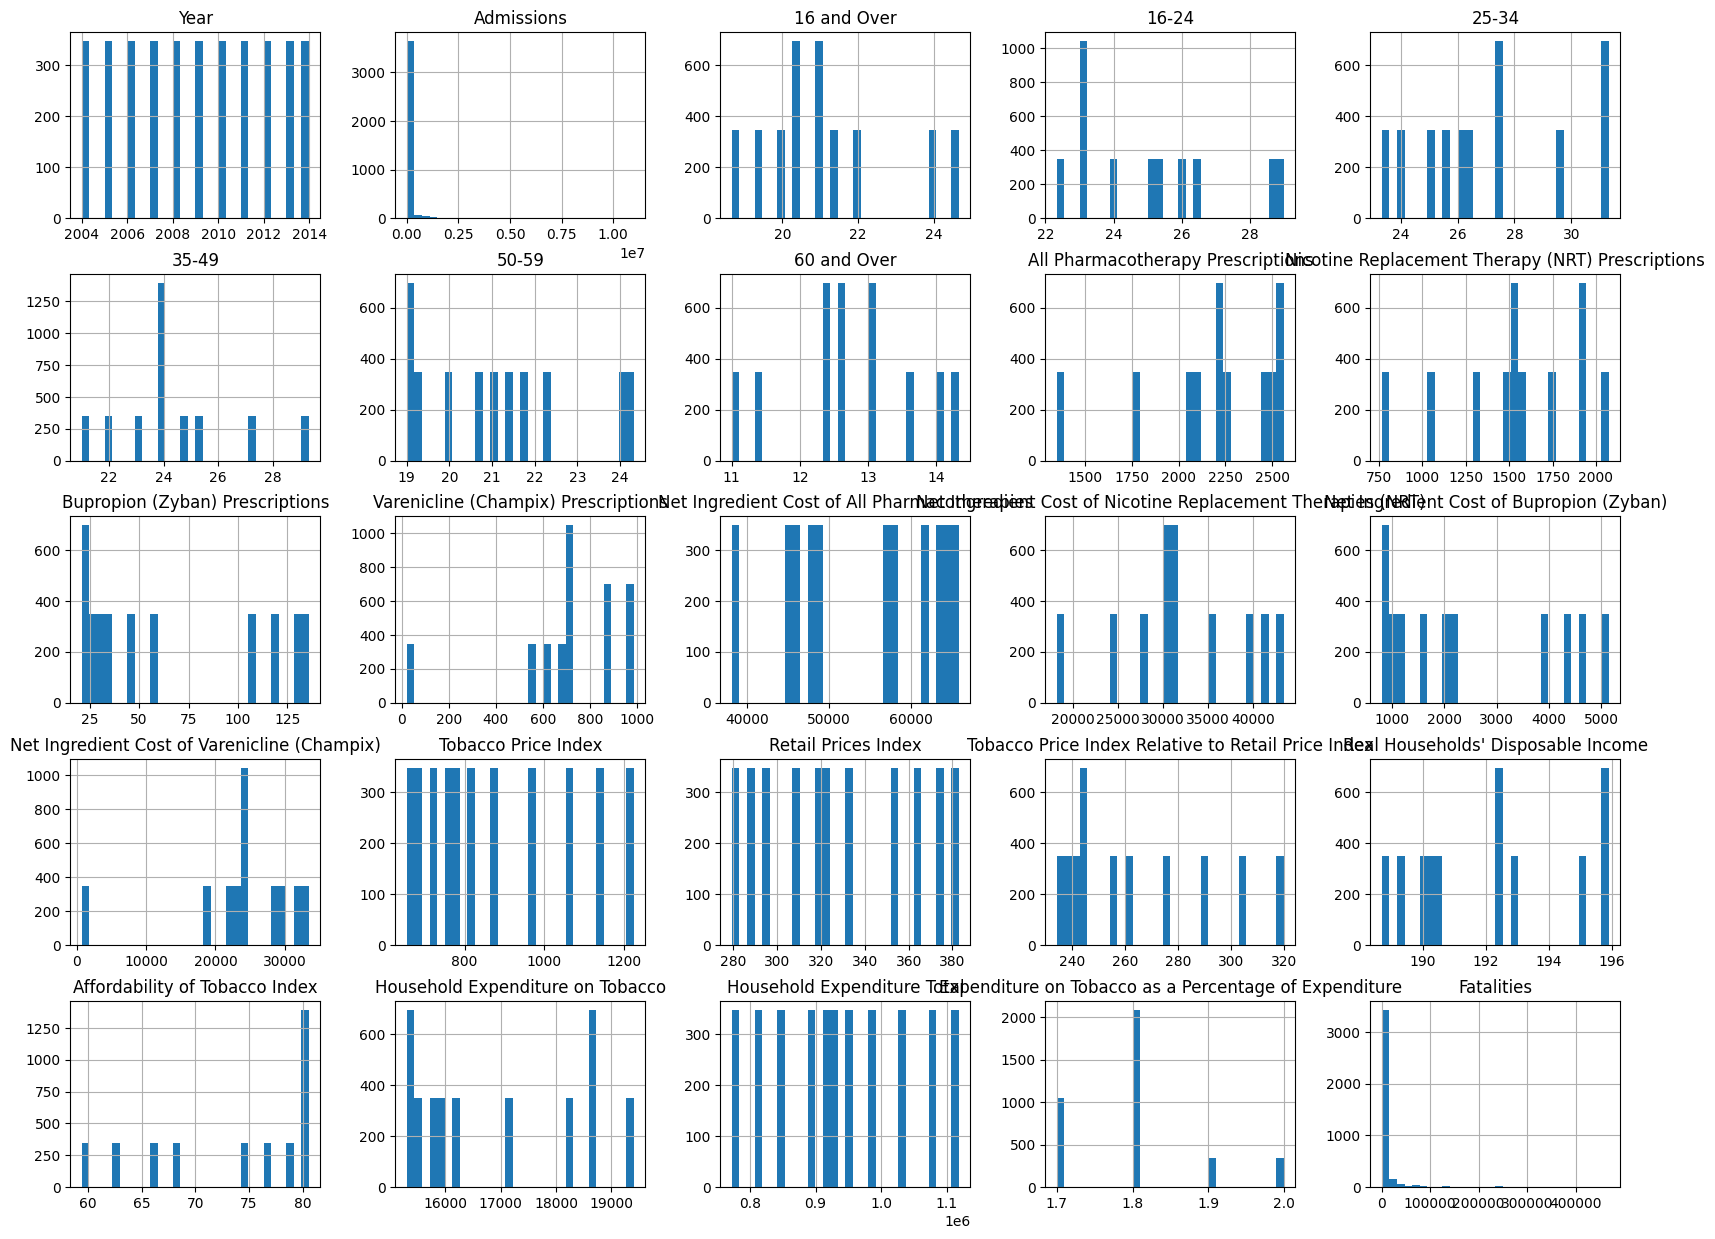

In [24]:
# Histograms for numeric features
df.hist(bins=30, figsize=(20, 15))
plt.show()

In [25]:
# -------------------------------------------------
# STEP 1: Compute correlation matrix (numeric columns only)
# -------------------------------------------------
corr_matrix = df.corr(numeric_only=True)

# Display top 5 rows in terminal / notebook
print("\nCorrelation matrix (top 5 rows):")
print(corr_matrix.head())


Correlation matrix (top 5 rows):
                 Year  Admissions  16 and Over     16-24     25-34     35-49  \
Year         1.000000    0.012180    -0.934687 -0.908804 -0.831917 -0.909952   
Admissions   0.012180    1.000000    -0.011409 -0.007381 -0.010858 -0.013076   
16 and Over -0.934687   -0.011409     1.000000  0.918967  0.918446  0.971309   
16-24       -0.908804   -0.007381     0.918967  1.000000  0.762321  0.873577   
25-34       -0.831917   -0.010858     0.918446  0.762321  1.000000  0.832929   

                50-59  60 and Over  All Pharmacotherapy Prescriptions  \
Year        -0.925500    -0.677906                          -0.362393   
Admissions  -0.009975    -0.010666                          -0.008487   
16 and Over  0.973708     0.746527                           0.222896   
16-24        0.902047     0.633208                           0.143960   
25-34        0.953507     0.539948                           0.033960   

             Nicotine Replacement Therapy (NRT

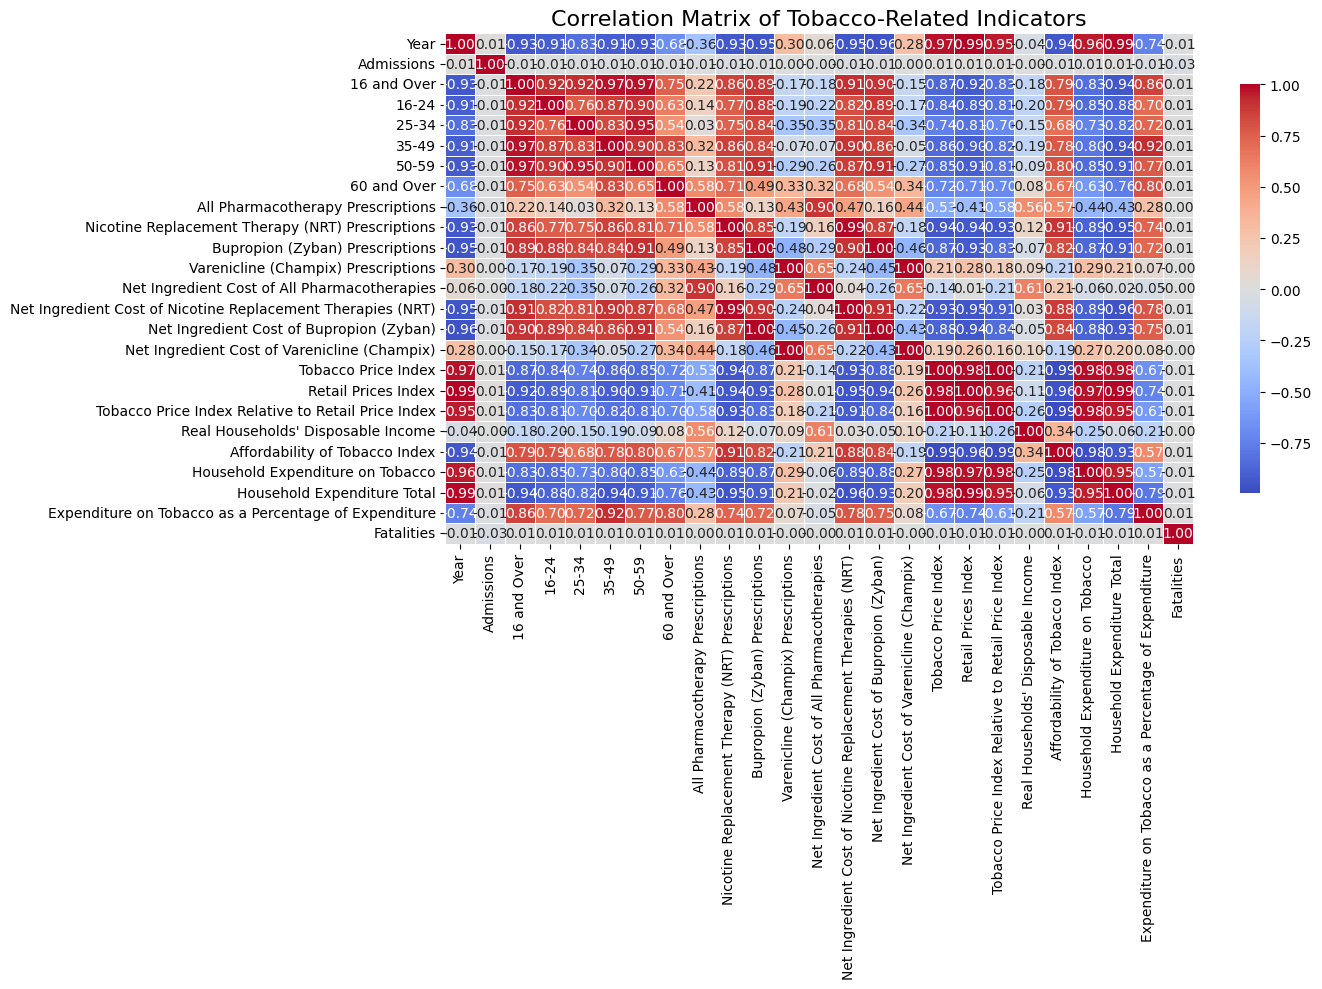

In [26]:
# -------------------------------------------------
# STEP 2: Plot the full correlation heatmap
# -------------------------------------------------
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",       # color gradient from red→blue
    annot=True,            # show numeric values
    fmt=".2f",             # format of correlation coefficient
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix of Tobacco-Related Indicators", fontsize=16)
plt.tight_layout()
plt.show()

In [27]:
df.columns

Index(['Year', 'ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type', 'Metric',
       'Sex', 'Admissions', '16 and Over', '16-24', '25-34', '35-49', '50-59',
       '60 and Over', 'All Pharmacotherapy Prescriptions',
       'Nicotine Replacement Therapy (NRT) Prescriptions',
       'Bupropion (Zyban) Prescriptions',
       'Varenicline (Champix) Prescriptions',
       'Net Ingredient Cost of All Pharmacotherapies',
       'Net Ingredient Cost of Nicotine Replacement Therapies (NRT)',
       'Net Ingredient Cost of Bupropion (Zyban)',
       'Net Ingredient Cost of Varenicline (Champix)', 'Tobacco Price Index',
       'Retail Prices Index',
       'Tobacco Price Index Relative to Retail Price Index',
       'Real Households' Disposable Income', 'Affordability of Tobacco Index',
       'Household Expenditure on Tobacco', 'Household Expenditure Total',
       'Expenditure on Tobacco as a Percentage of Expenditure',
       'source_dataset', 'Fatalities'],
      dtype='object')

In [28]:
df.shape

(3828, 31)

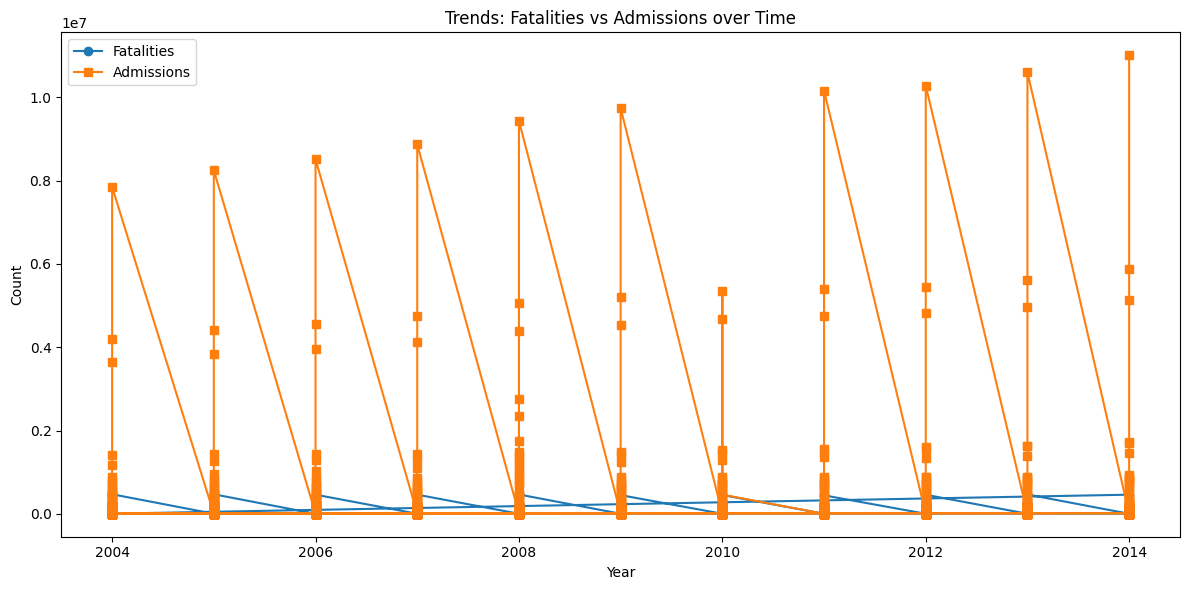

In [29]:
# --- Trend of fatalities and admissions over years ---
plt.figure(figsize=(12,6))
plt.plot(df["Year"], df["Fatalities"], marker='o', label="Fatalities")
plt.plot(df["Year"], df["Admissions"], marker='s', label="Admissions")
plt.title("Trends: Fatalities vs Admissions over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

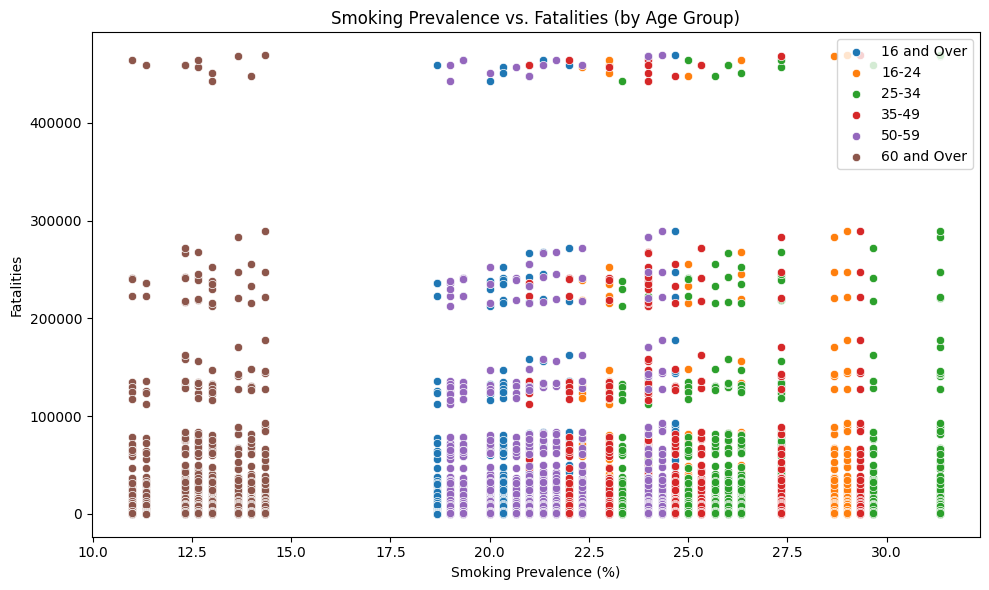

In [30]:
# --- Smoking prevalence vs. fatalities ---
smoking_cols = ["16 and Over", "16-24", "25-34", "35-49", "50-59", "60 and Over"]
plt.figure(figsize=(10,6))
for col in smoking_cols:
    if col in df.columns:
        sns.scatterplot(x=df[col], y=df["Fatalities"], label=col)
plt.title("Smoking Prevalence vs. Fatalities (by Age Group)")
plt.xlabel("Smoking Prevalence (%)")
plt.ylabel("Fatalities")
plt.legend()
plt.tight_layout()
plt.show()

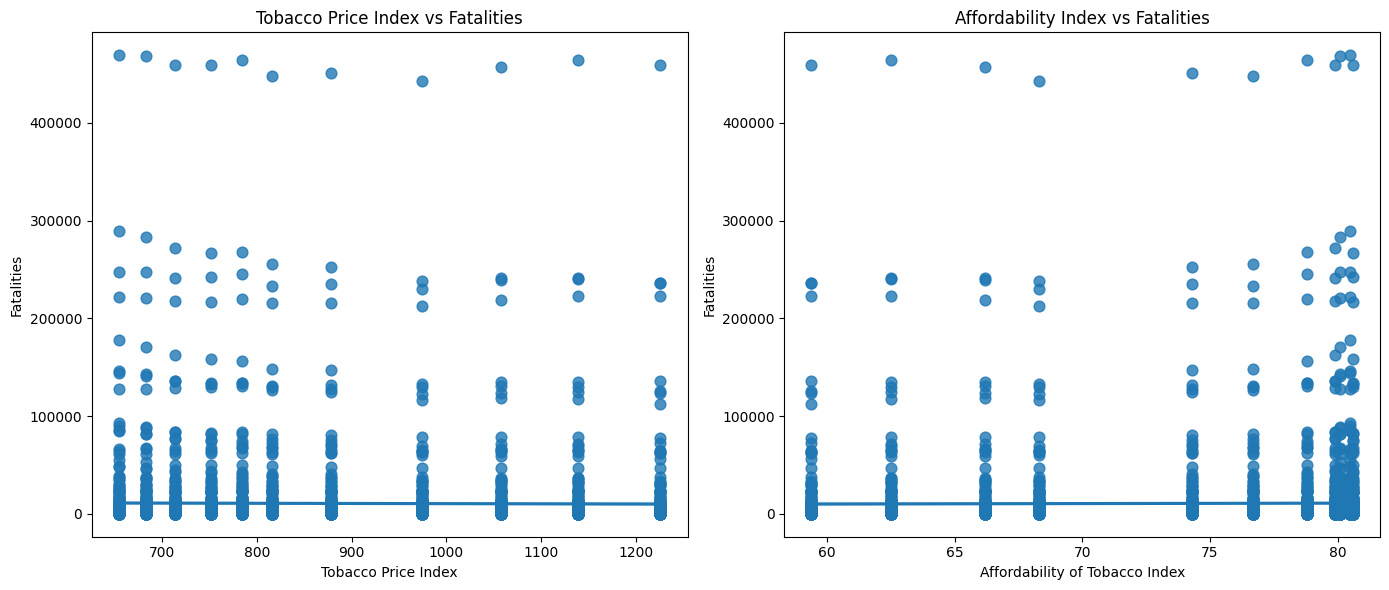

In [31]:
# --- 4. Price and affordability vs fatalities ---
fig, axes = plt.subplots(1, 2, figsize=(14,6))
sns.regplot(ax=axes[0], data=df, x="Tobacco Price Index", y="Fatalities", scatter_kws={"s":60})
axes[0].set_title("Tobacco Price Index vs Fatalities")
sns.regplot(ax=axes[1], data=df, x="Affordability of Tobacco Index", y="Fatalities", scatter_kws={"s":60})
axes[1].set_title("Affordability Index vs Fatalities")
plt.tight_layout()
plt.show()

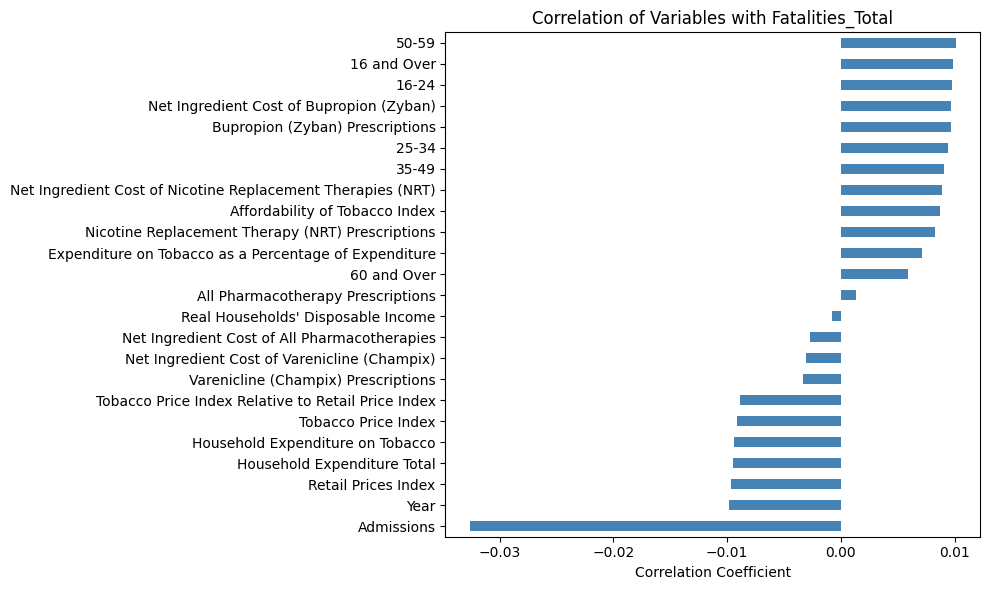

In [32]:
# --- 5. Correlation with target ---
corr_matrix = df.corr(numeric_only=True)
corr_with_fatalities = corr_matrix["Fatalities"].sort_values(ascending=False)
plt.figure(figsize=(10,6))
corr_with_fatalities.drop("Fatalities").sort_values().plot(kind="barh", color="steelblue")
plt.title("Correlation of Variables with Fatalities_Total")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

Feature Engineering

In [33]:
# Target variable = Fatalities
target = "Fatalities"

In [34]:
mortality_df = df[df["source_dataset"] == "fatalities"].copy()
mortality_df.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Admissions,16 and Over,16-24,25-34,...,Tobacco Price Index,Retail Prices Index,Tobacco Price Index Relative to Retail Price Index,Real Households' Disposable Income,Affordability of Tobacco Index,Household Expenditure on Tobacco,Household Expenditure Total,Expenditure on Tobacco as a Percentage of Expenditure,source_dataset,Fatalities
2079,2014,All codes,All deaths,All deaths,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,fatalities,459087.0
2080,2014,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,fatalities,235820.0
2081,2014,C00-D48,All cancers,All cancers,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,fatalities,136312.0
2082,2014,J00-J99,All respiratory diseases,All respiratory diseases,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,fatalities,61744.0
2083,2014,I00-I99,All circulatory diseases,All circulatory diseases,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,fatalities,126101.0


In [35]:
mortality_df.shape

(1749, 31)

In [36]:
mortality_df.columns

Index(['Year', 'ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type', 'Metric',
       'Sex', 'Admissions', '16 and Over', '16-24', '25-34', '35-49', '50-59',
       '60 and Over', 'All Pharmacotherapy Prescriptions',
       'Nicotine Replacement Therapy (NRT) Prescriptions',
       'Bupropion (Zyban) Prescriptions',
       'Varenicline (Champix) Prescriptions',
       'Net Ingredient Cost of All Pharmacotherapies',
       'Net Ingredient Cost of Nicotine Replacement Therapies (NRT)',
       'Net Ingredient Cost of Bupropion (Zyban)',
       'Net Ingredient Cost of Varenicline (Champix)', 'Tobacco Price Index',
       'Retail Prices Index',
       'Tobacco Price Index Relative to Retail Price Index',
       'Real Households' Disposable Income', 'Affordability of Tobacco Index',
       'Household Expenditure on Tobacco', 'Household Expenditure Total',
       'Expenditure on Tobacco as a Percentage of Expenditure',
       'source_dataset', 'Fatalities'],
      dtype='object')

In [37]:
mortality_df = mortality_df.drop(columns=["source_dataset"], errors="ignore")
mortality_df.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Admissions,16 and Over,16-24,25-34,...,Net Ingredient Cost of Varenicline (Champix),Tobacco Price Index,Retail Prices Index,Tobacco Price Index Relative to Retail Price Index,Real Households' Disposable Income,Affordability of Tobacco Index,Household Expenditure on Tobacco,Household Expenditure Total,Expenditure on Tobacco as a Percentage of Expenditure,Fatalities
2079,2014,All codes,All deaths,All deaths,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,19129.0,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,459087.0
2080,2014,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,19129.0,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,235820.0
2081,2014,C00-D48,All cancers,All cancers,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,19129.0,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,136312.0
2082,2014,J00-J99,All respiratory diseases,All respiratory diseases,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,19129.0,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,61744.0
2083,2014,I00-I99,All circulatory diseases,All circulatory diseases,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,19129.0,1226.0,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,126101.0


In [38]:
mortality_df["Year_Since_Start"] = mortality_df["Year"] - mortality_df["Year"].min()
mortality_df["Year_Squared"] = mortality_df["Year_Since_Start"] ** 2  # non-linear trend
mortality_df.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Admissions,16 and Over,16-24,25-34,...,Retail Prices Index,Tobacco Price Index Relative to Retail Price Index,Real Households' Disposable Income,Affordability of Tobacco Index,Household Expenditure on Tobacco,Household Expenditure Total,Expenditure on Tobacco as a Percentage of Expenditure,Fatalities,Year_Since_Start,Year_Squared
2079,2014,All codes,All deaths,All deaths,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,459087.0,10,100
2080,2014,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,235820.0,10,100
2081,2014,C00-D48,All cancers,All cancers,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,136312.0,10,100
2082,2014,J00-J99,All respiratory diseases,All respiratory diseases,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,61744.0,10,100
2083,2014,I00-I99,All circulatory diseases,All circulatory diseases,Number of observed deaths,All,12698.0,18.666667,23.0,24.0,...,383.0,320.1,190.0,59.4,19411.0,1118992.0,1.7,126101.0,10,100


In [39]:
mortality_df = mortality_df.sort_values(by="Year")
for col in ["Fatalities", "Admissions"]:
    if col in mortality_df.columns:
        mortality_df[f"{col}_lag1"] = mortality_df[col].shift(1)
        mortality_df[f"{col}_lag2"] = mortality_df[col].shift(2)
mortality_df.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Admissions,16 and Over,16-24,25-34,...,Household Expenditure on Tobacco,Household Expenditure Total,Expenditure on Tobacco as a Percentage of Expenditure,Fatalities,Year_Since_Start,Year_Squared,Fatalities_lag1,Fatalities_lag2,Admissions_lag1,Admissions_lag2
3827,2004,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,Female,12698.0,24.666667,29.0,31.333333,...,15375.0,772164.0,2.0,900.0,0,0,NaN,NaN,NaN,NaN
3724,2004,C00-D48,All cancers,All cancers,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,15375.0,772164.0,2.0,66765.0,0,0,900.0,NaN,12698.0,NaN
3723,2004,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,15375.0,772164.0,2.0,143800.0,0,0,66765.0,900.0,12698.0,12698.0
3722,2004,All codes,All deaths,All deaths,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,15375.0,772164.0,2.0,221731.0,0,0,143800.0,66765.0,12698.0,12698.0
3721,2004,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,All,12698.0,24.666667,29.0,31.333333,...,15375.0,772164.0,2.0,1800.0,0,0,221731.0,143800.0,12698.0,12698.0


In [40]:
# Admissions to Fatalities ratio — healthcare vs mortality
mortality_df["Admissions_per_Fatality"] = mortality_df["Admissions"] / (mortality_df["Fatalities"] + 1e-6)

# Relative change in Admissions year-to-year
mortality_df["Admissions_YoY_Change"] = mortality_df["Admissions"].pct_change()

# Relative change in Fatalities
mortality_df["Fatalities_YoY_Change"] = mortality_df["Fatalities"].pct_change()
mortality_df.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Admissions,16 and Over,16-24,25-34,...,Fatalities,Year_Since_Start,Year_Squared,Fatalities_lag1,Fatalities_lag2,Admissions_lag1,Admissions_lag2,Admissions_per_Fatality,Admissions_YoY_Change,Fatalities_YoY_Change
3827,2004,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,Female,12698.0,24.666667,29.0,31.333333,...,900.0,0,0,NaN,NaN,NaN,NaN,14.108889,NaN,NaN
3724,2004,C00-D48,All cancers,All cancers,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,66765.0,0,0,900.0,NaN,12698.0,NaN,0.190189,0.0,73.183333
3723,2004,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,143800.0,0,0,66765.0,900.0,12698.0,12698.0,0.088303,0.0,1.153823
3722,2004,All codes,All deaths,All deaths,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,221731.0,0,0,143800.0,66765.0,12698.0,12698.0,0.057268,0.0,0.541940
3721,2004,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,All,12698.0,24.666667,29.0,31.333333,...,1800.0,0,0,221731.0,143800.0,12698.0,12698.0,7.054444,0.0,-0.991882


In [41]:
for col in ["Admissions", "Fatalities"]:
    mortality_df[f"{col}_rolling_mean3"] = mortality_df[col].rolling(window=3, min_periods=1).mean()
    mortality_df[f"{col}_rolling_std3"] = mortality_df[col].rolling(window=3, min_periods=1).std()
mortality_df.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Admissions,16 and Over,16-24,25-34,...,Fatalities_lag2,Admissions_lag1,Admissions_lag2,Admissions_per_Fatality,Admissions_YoY_Change,Fatalities_YoY_Change,Admissions_rolling_mean3,Admissions_rolling_std3,Fatalities_rolling_mean3,Fatalities_rolling_std3
3827,2004,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,Female,12698.0,24.666667,29.0,31.333333,...,NaN,NaN,NaN,14.108889,NaN,NaN,12698.0,NaN,900.000000,NaN
3724,2004,C00-D48,All cancers,All cancers,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,NaN,12698.0,NaN,0.190189,0.0,73.183333,12698.0,0.0,33832.500000,46573.588143
3723,2004,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,900.0,12698.0,12698.0,0.088303,0.0,1.153823,12698.0,0.0,70488.333333,71522.723021
3722,2004,All codes,All deaths,All deaths,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,66765.0,12698.0,12698.0,0.057268,0.0,0.541940,12698.0,0.0,144098.666667,77483.431715
3721,2004,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,All,12698.0,24.666667,29.0,31.333333,...,143800.0,12698.0,12698.0,7.054444,0.0,-0.991882,12698.0,0.0,122443.666667,111510.003678


In [42]:
for col in ["Admissions", "Fatalities"]:
    mortality_df[f"log_{col}"] = np.log1p(mortality_df[col])
mortality_df.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Admissions,16 and Over,16-24,25-34,...,Admissions_lag2,Admissions_per_Fatality,Admissions_YoY_Change,Fatalities_YoY_Change,Admissions_rolling_mean3,Admissions_rolling_std3,Fatalities_rolling_mean3,Fatalities_rolling_std3,log_Admissions,log_Fatalities
3827,2004,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,Female,12698.0,24.666667,29.0,31.333333,...,NaN,14.108889,NaN,NaN,12698.0,NaN,900.000000,NaN,9.449279,6.803505
3724,2004,C00-D48,All cancers,All cancers,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,NaN,0.190189,0.0,73.183333,12698.0,0.0,33832.500000,46573.588143,9.449279,11.108949
3723,2004,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,12698.0,0.088303,0.0,1.153823,12698.0,0.0,70488.333333,71522.723021,9.449279,11.876186
3722,2004,All codes,All deaths,All deaths,Number of observed deaths,Male,12698.0,24.666667,29.0,31.333333,...,12698.0,0.057268,0.0,0.541940,12698.0,0.0,144098.666667,77483.431715,9.449279,12.309225
3721,2004,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,All,12698.0,24.666667,29.0,31.333333,...,12698.0,7.054444,0.0,-0.991882,12698.0,0.0,122443.666667,111510.003678,9.449279,7.496097


In [43]:
mortality_df = mortality_df.drop(columns=["Year", "Net Ingredient Cost of Varenicline (Champix)", "Year_Squared", "Net Ingredient Cost of Bupropion (Zyban)", "Tobacco Price Index", "Retail Prices Index", "Tobacco Price Index Relative to Retail Price Index", "Net Ingredient Cost of Nicotine Replacement Therapies (NRT)", "Household Expenditure Total", "Household Expenditure on Tobacco", "16 and Over", "Year_Since_Start"], errors="ignore")
mortality_df.head()

,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Admissions,16-24,25-34,35-49,50-59,...,Admissions_lag2,Admissions_per_Fatality,Admissions_YoY_Change,Fatalities_YoY_Change,Admissions_rolling_mean3,Admissions_rolling_std3,Fatalities_rolling_mean3,Fatalities_rolling_std3,log_Admissions,log_Fatalities
3827,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,Female,12698.0,29.0,31.333333,29.333333,24.333333,...,NaN,14.108889,NaN,NaN,12698.0,NaN,900.000000,NaN,9.449279,6.803505
3724,C00-D48,All cancers,All cancers,Number of observed deaths,Male,12698.0,29.0,31.333333,29.333333,24.333333,...,NaN,0.190189,0.0,73.183333,12698.0,0.0,33832.500000,46573.588143,9.449279,11.108949
3723,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All deaths which can be caused by smoking,All deaths which can be caused by smoking,Number of observed deaths,Male,12698.0,29.0,31.333333,29.333333,24.333333,...,12698.0,0.088303,0.0,1.153823,12698.0,0.0,70488.333333,71522.723021,9.449279,11.876186
3722,All codes,All deaths,All deaths,Number of observed deaths,Male,12698.0,29.0,31.333333,29.333333,24.333333,...,12698.0,0.057268,0.0,0.541940,12698.0,0.0,144098.666667,77483.431715,9.449279,12.309225
3721,K25-K27,Stomach / Duodenal Ulcer,Digestive diseases which can be caused caused ...,Attributable number,All,12698.0,29.0,31.333333,29.333333,24.333333,...,12698.0,7.054444,0.0,-0.991882,12698.0,0.0,122443.666667,111510.003678,9.449279,7.496097


In [44]:
mortality_df = mortality_df.dropna(subset=[
    "Fatalities_lag1", "Fatalities_lag2",
    "Admissions_lag1", "Admissions_lag2"
])

In [45]:
mortality_df.isnull().sum()

ICD10 Code                                               0
ICD10 Diagnosis                                          0
Diagnosis Type                                           0
Metric                                                   0
Sex                                                      0
Admissions                                               0
16-24                                                    0
25-34                                                    0
35-49                                                    0
50-59                                                    0
60 and Over                                              0
All Pharmacotherapy Prescriptions                        0
Nicotine Replacement Therapy (NRT) Prescriptions         0
Bupropion (Zyban) Prescriptions                          0
Varenicline (Champix) Prescriptions                      0
Net Ingredient Cost of All Pharmacotherapies             0
Real Households' Disposable Income                      

In [46]:
y = mortality_df["Fatalities"]
X = mortality_df.drop(columns=["Fatalities"])

In [47]:
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols.tolist())

Non-numeric columns: ['ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type', 'Metric', 'Sex']


In [48]:
X = X.drop(columns=['ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type', 'Metric'])
X.head()

,Sex,Admissions,16-24,25-34,35-49,50-59,60 and Over,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,Bupropion (Zyban) Prescriptions,...,Admissions_lag2,Admissions_per_Fatality,Admissions_YoY_Change,Fatalities_YoY_Change,Admissions_rolling_mean3,Admissions_rolling_std3,Fatalities_rolling_mean3,Fatalities_rolling_std3,log_Admissions,log_Fatalities
3723,Male,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,...,12698.0,0.088303,0.0,1.153823,12698.0,0.0,70488.333333,71522.723021,9.449279,11.876186
3722,Male,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,...,12698.0,0.057268,0.0,0.541940,12698.0,0.0,144098.666667,77483.431715,9.449279,12.309225
3721,All,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,...,12698.0,7.054444,0.0,-0.991882,12698.0,0.0,122443.666667,111510.003678,9.449279,7.496097
3720,All,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,...,12698.0,63.490000,0.0,-0.888889,12698.0,0.0,74577.000000,127441.613247,9.449279,5.303305
3719,All,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,...,12698.0,2.441923,0.0,25.000000,12698.0,0.0,2400.000000,2553.429067,9.449279,8.556606


In [49]:
# One-hot encode 'Sex' column
X_encoded = pd.get_dummies(X, columns=['Sex'], drop_first=False)

# Preview
X_encoded.head()

,Admissions,16-24,25-34,35-49,50-59,60 and Over,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,Bupropion (Zyban) Prescriptions,Varenicline (Champix) Prescriptions,...,Fatalities_YoY_Change,Admissions_rolling_mean3,Admissions_rolling_std3,Fatalities_rolling_mean3,Fatalities_rolling_std3,log_Admissions,log_Fatalities,Sex_All,Sex_Female,Sex_Male
3723,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,714.0,...,1.153823,12698.0,0.0,70488.333333,71522.723021,9.449279,11.876186,False,False,True
3722,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,714.0,...,0.541940,12698.0,0.0,144098.666667,77483.431715,9.449279,12.309225,False,False,True
3721,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,714.0,...,-0.991882,12698.0,0.0,122443.666667,111510.003678,9.449279,7.496097,True,False,False
3720,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,714.0,...,-0.888889,12698.0,0.0,74577.000000,127441.613247,9.449279,5.303305,True,False,False
3719,12698.0,29.0,31.333333,29.333333,24.333333,14.333333,2044.0,1908.0,136.0,714.0,...,25.000000,12698.0,0.0,2400.000000,2553.429067,9.449279,8.556606,True,False,False


In [50]:
# --- Parameters you can tweak ---
LOWER_Q = 0.01    # winsorize lower quantile
UPPER_Q = 0.99    # winsorize upper quantile
LARGE_THRESHOLD = 1e12   # optional threshold to consider "too large" (for reporting)
# -------------------------------

def detect_problems(df, large_threshold=LARGE_THRESHOLD):
    num = df.select_dtypes(include=["number"]).columns.tolist()
    problems = {}
    for c in num:
        s = df[c]
        n_inf = np.isinf(s).sum()
        n_nan = s.isna().sum()
        n_large = (s.abs() > large_threshold).sum()
        if n_inf or n_nan or n_large:
            problems[c] = {"inf": int(n_inf), "nan": int(n_nan), "large": int(n_large),
                           "min": float(np.nanmin(s.replace([np.inf, -np.inf], np.nan))) if s.notna().any() else np.nan,
                           "max": float(np.nanmax(s.replace([np.inf, -np.inf], np.nan))) if s.notna().any() else np.nan}
    return problems

def clean_winsorize_impute(df, lower_q=LOWER_Q, upper_q=UPPER_Q):
    X = df.copy()
    # Only operate on numeric columns (one-hot cols are numeric already)
    num_cols = X.select_dtypes(include=["number"]).columns.tolist()
    print(f"Numeric columns to clean: {len(num_cols)}")

    # 1) replace inf with NaN
    X[num_cols] = X[num_cols].replace([np.inf, -np.inf], np.nan)

    # 2) compute quantile caps
    q_low = X[num_cols].quantile(lower_q)
    q_high = X[num_cols].quantile(upper_q)

    # 3) apply caps (winsorize)
    for c in num_cols:
        lo = q_low[c]
        hi = q_high[c]
        if np.isfinite(lo) and np.isfinite(hi):
            X[c] = X[c].clip(lower=lo, upper=hi)
        else:
            # if quantiles not finite (all NaNs), leave as is
            pass

    # 4) median impute remaining NaNs
    med = X[num_cols].median()
    X[num_cols] = X[num_cols].fillna(med)

    return X

# ------------- usage --------------
# assume X_encoded is your pd.DataFrame after pd.get_dummies(...)
print("Pre-clean problems (sample):")
probs_before = detect_problems(X_encoded)
# print top 10 problem columns sorted by largest absolute max
if len(probs_before) == 0:
    print("No inf/NaN/huge problems detected before cleaning.")
else:
    # show columns with issues and short summary (top 10)
    sorted_before = sorted(probs_before.items(), key=lambda kv: max(abs(kv[1].get("min",0)), abs(kv[1].get("max",0))), reverse=True)
    for k, v in sorted_before[:10]:
        print(k, v)

# Clean
X_clean = clean_winsorize_impute(X_encoded, lower_q=LOWER_Q, upper_q=UPPER_Q)

# Post-clean diagnostics
print("\nPost-clean problems (should be empty):")
probs_after = detect_problems(X_clean)
if not probs_after:
    print("No inf/NaN/huge values detected after cleaning.")
else:
    for k, v in list(probs_after.items())[:10]:
        print(k, v)

# Now scale
num_cols_final = X_clean.select_dtypes(include=["number"]).columns.tolist()
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_clean[num_cols_final])
X_scaled = pd.DataFrame(X_scaled_array, columns=num_cols_final, index=X_clean.index)

print("\nScaling complete. Shape:", X_scaled.shape)

# Quick sanity checks
print("Any NaNs in X_scaled?", X_scaled.isna().sum().sum())
print("Max abs value in X_scaled (should be finite):", np.nanmax(np.abs(X_scaled.values)))

# X_scaled is ready for modeling

Pre-clean problems (sample):
Fatalities_YoY_Change {'inf': 20, 'nan': 0, 'large': 20, 'min': -1.0, 'max': 1202.685}
Numeric columns to clean: 27

Post-clean problems (should be empty):
No inf/NaN/huge values detected after cleaning.

Scaling complete. Shape: (1747, 27)
Any NaNs in X_scaled? 0
Max abs value in X_scaled (should be finite): 9.292470069900679


In [51]:
X_scaled.head()

,Admissions,16-24,25-34,35-49,50-59,60 and Over,All Pharmacotherapy Prescriptions,Nicotine Replacement Therapy (NRT) Prescriptions,Bupropion (Zyban) Prescriptions,Varenicline (Champix) Prescriptions,...,Admissions_lag2,Admissions_per_Fatality,Admissions_YoY_Change,Fatalities_YoY_Change,Admissions_rolling_mean3,Admissions_rolling_std3,Fatalities_rolling_mean3,Fatalities_rolling_std3,log_Admissions,log_Fatalities
3723,0.0,1.809269,1.65649,2.227365,1.812087,1.618906,-0.38824,0.989894,1.574775,0.050759,...,0.0,-0.107614,0.0,-0.242797,0.0,0.0,1.509867,1.382662,1.776357e-15,1.847545
3722,0.0,1.809269,1.65649,2.227365,1.812087,1.618906,-0.38824,0.989894,1.574775,0.050759,...,0.0,-0.107614,0.0,-0.272775,0.0,0.0,3.670679,1.540769,1.776357e-15,2.056878
3721,0.0,1.809269,1.65649,2.227365,1.812087,1.618906,-0.38824,0.989894,1.574775,0.050759,...,0.0,-0.107614,0.0,-0.347923,0.0,0.0,3.035002,2.443318,1.776357e-15,-0.269813
3720,0.0,1.809269,1.65649,2.227365,1.812087,1.618906,-0.38824,0.989894,1.574775,0.050759,...,0.0,-0.107614,0.0,-0.342877,0.0,0.0,1.629889,2.865901,1.776357e-15,-1.329820
3719,0.0,1.809269,1.65649,2.227365,1.812087,1.618906,-0.38824,0.989894,1.574775,0.050759,...,0.0,-0.107614,0.0,0.925523,0.0,0.0,-0.488848,-0.446737,1.776357e-15,0.242843


In [52]:
X_scaled.columns

Index(['Admissions', '16-24', '25-34', '35-49', '50-59', '60 and Over',
       'All Pharmacotherapy Prescriptions',
       'Nicotine Replacement Therapy (NRT) Prescriptions',
       'Bupropion (Zyban) Prescriptions',
       'Varenicline (Champix) Prescriptions',
       'Net Ingredient Cost of All Pharmacotherapies',
       'Real Households' Disposable Income', 'Affordability of Tobacco Index',
       'Expenditure on Tobacco as a Percentage of Expenditure',
       'Fatalities_lag1', 'Fatalities_lag2', 'Admissions_lag1',
       'Admissions_lag2', 'Admissions_per_Fatality', 'Admissions_YoY_Change',
       'Fatalities_YoY_Change', 'Admissions_rolling_mean3',
       'Admissions_rolling_std3', 'Fatalities_rolling_mean3',
       'Fatalities_rolling_std3', 'log_Admissions', 'log_Fatalities'],
      dtype='object')

In [53]:
X_scaled.to_csv("combined_tobacco_dataset.csv", index=False)
y.to_csv("target_value.csv", index=False)

Model Selection

In [54]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [55]:
warnings.filterwarnings("ignore")

# -----------------------
# Config
# -----------------------

RANDOM_STATE = 42
TEST_SIZE = 0.2
DO_HYPERPARAM_TUNING = True  # set False to skip expensive GridSearchCV

In [56]:
# -----------------------
# Regression pipelines
# -----------------------
pipelines_reg = {
    "Linear Regression": Pipeline([("scaler", StandardScaler()), ("model", LinearRegression())]),
    "Ridge": Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=RANDOM_STATE))]),
    "Lasso": Pipeline([("scaler", StandardScaler()), ("model", Lasso(random_state=RANDOM_STATE))]),
    "Random Forest": Pipeline([("scaler", StandardScaler()), ("model", RandomForestRegressor(random_state=RANDOM_STATE))]),
    "Gradient Boosting": Pipeline([("scaler", StandardScaler()), ("model", GradientBoostingRegressor(random_state=RANDOM_STATE))]),
    "SVR": Pipeline([("scaler", StandardScaler()), ("model", SVR(kernel='rbf'))]),
    "KNN": Pipeline([("scaler", StandardScaler()), ("model", KNeighborsRegressor())])
}

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Evaluate regression models
reg_results = []
for name, pipe in pipelines_reg.items():
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    reg_results.append({
        "Model": name,
        "Test_RMSE": rmse(y_test, preds),
        "Test_R2": r2_score(y_test, preds),
        "CV_R2_train": cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2', n_jobs=-1).mean()
    })

reg_df = pd.DataFrame(reg_results).sort_values(by="Test_R2", ascending=False).reset_index(drop=True)
print("\nRegression model comparison:")
print(reg_df)
#reg_df.to_csv("regression_model_comparison.csv", index=False)


Regression model comparison:
               Model     Test_RMSE   Test_R2  CV_R2_train
0  Gradient Boosting   1626.305068  0.998918     0.981576
1      Random Forest   3129.233238  0.995995     0.979193
2                KNN  31001.094855  0.606895     0.694913
3              Ridge  31065.083640  0.605270     0.827317
4              Lasso  31084.612114  0.604774     0.827305
5  Linear Regression  31086.081045  0.604736     0.827287
6                SVR  51940.857290 -0.103502    -0.115481


In [57]:
# -----------------------
# Optional hyperparameter tuning (regression)
# -----------------------
if DO_HYPERPARAM_TUNING:
    rf_param_grid = {
        "model__n_estimators": [100, 300],
        "model__max_depth": [None, 6, 12],
        "model__min_samples_split": [2, 5]
    }
    gb_param_grid = {
        "model__n_estimators": [100, 300],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [3, 5]
    }

    print("\nTuning Random Forest...")
    rf_grid = GridSearchCV(pipelines_reg["Random Forest"], rf_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
    rf_grid.fit(X_train, y_train)
    print("RF best:", rf_grid.best_params_, "cv_r2:", rf_grid.best_score_)

    print("\nTuning Gradient Boosting...")
    gb_grid = GridSearchCV(pipelines_reg["Gradient Boosting"], gb_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
    gb_grid.fit(X_train, y_train)
    print("GB best:", gb_grid.best_params_, "cv_r2:", gb_grid.best_score_)

    # Evaluate tuned on test
    for nm, grid in [("RF_tuned", rf_grid), ("GB_tuned", gb_grid)]:
        p = grid.predict(X_test)
        print(f"{nm} - Test R2: {r2_score(y_test, p):.4f}  Test RMSE: {rmse(y_test, p):.2f}")

    joblib.dump(rf_grid.best_estimator_, "models/rf_best_pipeline.joblib")
    joblib.dump(gb_grid.best_estimator_, "models/gb_best_pipeline.joblib")


Tuning Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
RF best: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 300} cv_r2: 0.9808427647635133

Tuning Gradient Boosting...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
GB best: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 300} cv_r2: 0.9815779406651546
RF_tuned - Test R2: 0.9954  Test RMSE: 3367.51
GB_tuned - Test R2: 0.9989  Test RMSE: 1634.89


In [58]:
# -----------------------
# Classification: build a binary target and evaluate Logistic Regression
# -----------------------
# Binary target creation:
# median split
threshold = y.median()

mortality_df["Fatalities_bin"] = (mortality_df["Fatalities"] > threshold).astype(int)
y_clf = mortality_df["Fatalities_bin"]

# Train/test split for classification (stratify to preserve class balance)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_scaled, y_clf, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_clf)

In [59]:
# Classifier pipeline
pipe_logistic = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter=2000))])

In [60]:
# Fit and evaluate
pipe_logistic.fit(Xc_train, yc_train)
yc_pred = pipe_logistic.predict(Xc_test)
yc_proba = pipe_logistic.predict_proba(Xc_test)[:, 1] if hasattr(pipe_logistic.named_steps['clf'], "predict_proba") else None

clf_results = {
    "accuracy": accuracy_score(yc_test, yc_pred),
    "precision": precision_score(yc_test, yc_pred, zero_division=0),
    "recall": recall_score(yc_test, yc_pred, zero_division=0),
    "f1": f1_score(yc_test, yc_pred, zero_division=0),
    "roc_auc": roc_auc_score(yc_test, yc_proba) if yc_proba is not None else np.nan,
    "cv_accuracy": cross_val_score(pipe_logistic, X_scaled, y_clf, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='accuracy', n_jobs=-1).mean()
}

print("\nLogistic Regression (binary target) results:")
print(clf_results)

# Save classifier
joblib.dump(pipe_logistic, "models/logistic_pipeline.joblib")


Logistic Regression (binary target) results:
{'accuracy': 0.9771428571428571, 'precision': 0.9717514124293786, 'recall': 0.9828571428571429, 'f1': 0.9772727272727273, 'roc_auc': 0.9991183673469388, 'cv_accuracy': 0.9914154727793697}


['models/logistic_pipeline.joblib']

In [61]:
# -----------------------
# Optional tuning for Logistic Regression (classification)
# -----------------------
if DO_HYPERPARAM_TUNING:
    log_param_grid = {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],  # sklearn's LogisticRegression with 'saga' and l1 could be enabled if desired
        "clf__solver": ["lbfgs"]
    }
    log_grid = GridSearchCV(pipe_logistic, log_param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE), scoring='accuracy', n_jobs=-1, verbose=1)
    log_grid.fit(Xc_train, yc_train)
    print("Logistic best params:", log_grid.best_params_, "best cv acc:", log_grid.best_score_)
    best_log = log_grid.best_estimator_
    ylp = best_log.predict(Xc_test)
    ylp_proba = best_log.predict_proba(Xc_test)[:,1] if hasattr(best_log.named_steps['clf'], "predict_proba") else None
    print("Tuned Logistic - accuracy:", accuracy_score(yc_test, ylp),
          "precision:", precision_score(yc_test, ylp, zero_division=0),
          "recall:", recall_score(yc_test, ylp, zero_division=0),
          "f1:", f1_score(yc_test, ylp, zero_division=0),
          "roc_auc:", (roc_auc_score(yc_test, ylp_proba) if ylp_proba is not None else np.nan))
    joblib.dump(log_grid.best_estimator_, "models/logistic_best_pipeline.joblib")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Logistic best params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'} best cv acc: 0.9928366615463389
Tuned Logistic - accuracy: 0.9885714285714285 precision: 0.9776536312849162 recall: 1.0 f1: 0.9887005649717514 roc_auc: 0.9995428571428571


In [62]:
# -----------------------
# Feature importance for regression trees and coefficients for logistic
# -----------------------
def get_feature_importances_from_pipeline(pipeline, feature_names):
    model = pipeline.named_steps.get("model") or pipeline.named_steps.get("clf")
    if hasattr(model, "feature_importances_"):
        return pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    elif hasattr(model, "coef_"):
        # logistic or linear coefficients
        coefs = np.abs(model.coef_).ravel()
        return pd.Series(coefs, index=feature_names).sort_values(ascending=False)
    else:
        return None

feature_names = X_scaled.columns.tolist()
fi = {}

# prefer tuned GB/RF if available
if os.path.exists("gb_best_pipeline.joblib"):
    fi_gb = get_feature_importances_from_pipeline(joblib.load("gb_best_pipeline.joblib"), feature_names)
    if fi_gb is not None: fi["GB_tuned"] = fi_gb
if os.path.exists("rf_best_pipeline.joblib"):
    fi_rf = get_feature_importances_from_pipeline(joblib.load("rf_best_pipeline.joblib"), feature_names)
    if fi_rf is not None: fi["RF_tuned"] = fi_rf

In [63]:
# fallback to untuned pipelines
if "GB_tuned" not in fi:
    fi_gb = get_feature_importances_from_pipeline(pipelines_reg["Gradient Boosting"], feature_names)
    if fi_gb is not None: fi["GB"] = fi_gb
if "RF_tuned" not in fi:
    fi_rf = get_feature_importances_from_pipeline(pipelines_reg["Random Forest"], feature_names)
    if fi_rf is not None: fi["RF"] = fi_rf

In [64]:
# logistic coefficients (untuned or tuned)
if os.path.exists("logistic_best_pipeline.joblib"):
    fi_log = get_feature_importances_from_pipeline(joblib.load("logistic_best_pipeline.joblib"), feature_names)
else:
    fi_log = get_feature_importances_from_pipeline(pipe_logistic, feature_names)
if fi_log is not None:
    fi["Logistic"] = fi_log

# Print top features
for k, s in fi.items():
    print(f"\nTop features for {k}:")
    print(s.head(15))


Top features for GB_tuned:
log_Fatalities                                           9.519718e-01
Fatalities_rolling_std3                                  3.848707e-02
Fatalities_YoY_Change                                    8.930331e-03
Fatalities_rolling_mean3                                 2.177229e-04
Fatalities_lag2                                          1.877628e-04
Real Households' Disposable Income                       1.397443e-04
Fatalities_lag1                                          2.460698e-05
Net Ingredient Cost of All Pharmacotherapies             1.316973e-05
All Pharmacotherapy Prescriptions                        1.107184e-05
Varenicline (Champix) Prescriptions                      8.425397e-06
Bupropion (Zyban) Prescriptions                          2.964713e-06
Expenditure on Tobacco as a Percentage of Expenditure    2.081120e-06
16-24                                                    8.217995e-07
50-59                                                    8.118

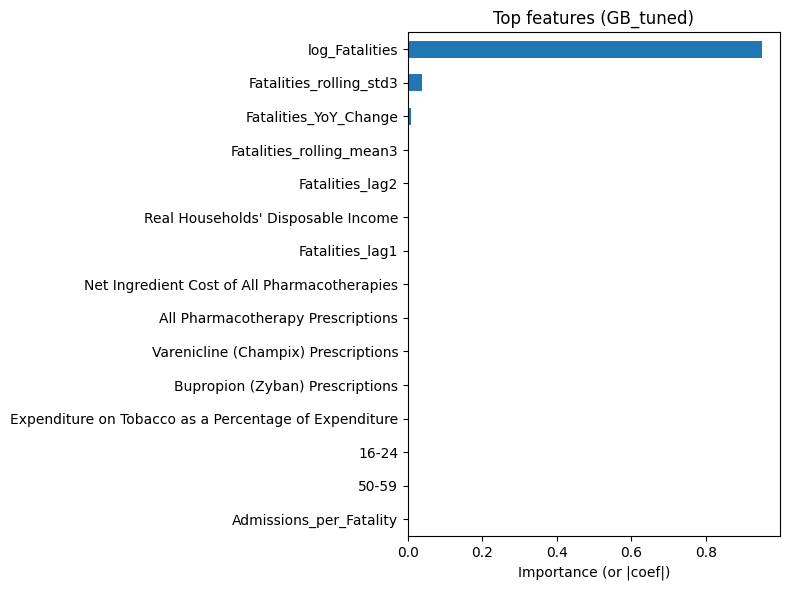


Done. Regression summary -> regression_model_comparison.csv ; classifier metrics printed above.


In [65]:
# plot top features of best available model
if fi:
    first_key = list(fi.keys())[0]
    top = fi[first_key].head(15)
    plt.figure(figsize=(8,6))
    top[::-1].plot.barh()
    plt.title(f"Top features ({first_key})")
    plt.xlabel("Importance (or |coef|)")
    plt.tight_layout()
    plt.savefig("feature_importance.png")
    plt.show()

print("\nDone. Regression summary -> regression_model_comparison.csv ; classifier metrics printed above.")

Model Interpretation

In [66]:
# ----------------------------------------------------------
# 1) Choose model: pick ONE of these lines
# ----------------------------------------------------------
pipeline_model = pipelines_reg["Gradient Boosting"]
# pipeline_model = pipelines_reg["Random Forest"]
# pipeline_model = joblib.load("gb_best_pipeline.joblib")
# pipeline_model = joblib.load("rf_best_pipeline.joblib")

In [67]:
# sample background from raw X_train
bg_size = min(300, len(X_train))
bg_idx = np.random.choice(len(X_train), bg_size, replace=False)
X_bg_raw = X_train.iloc[bg_idx]
joblib.dump(X_bg_raw, "models/X_bg_raw.joblib")

['models/X_bg_raw.joblib']

In [68]:
# pass a callable (pipeline.predict) as the model
explainer = shap.Explainer(pipeline_model.predict, X_bg_raw)   # pipeline_model.predict is callable
shap_exp = explainer(X_test)                                   # pass raw X_test DataFrame

PermutationExplainer explainer: 351it [00:13,  8.96it/s]                         


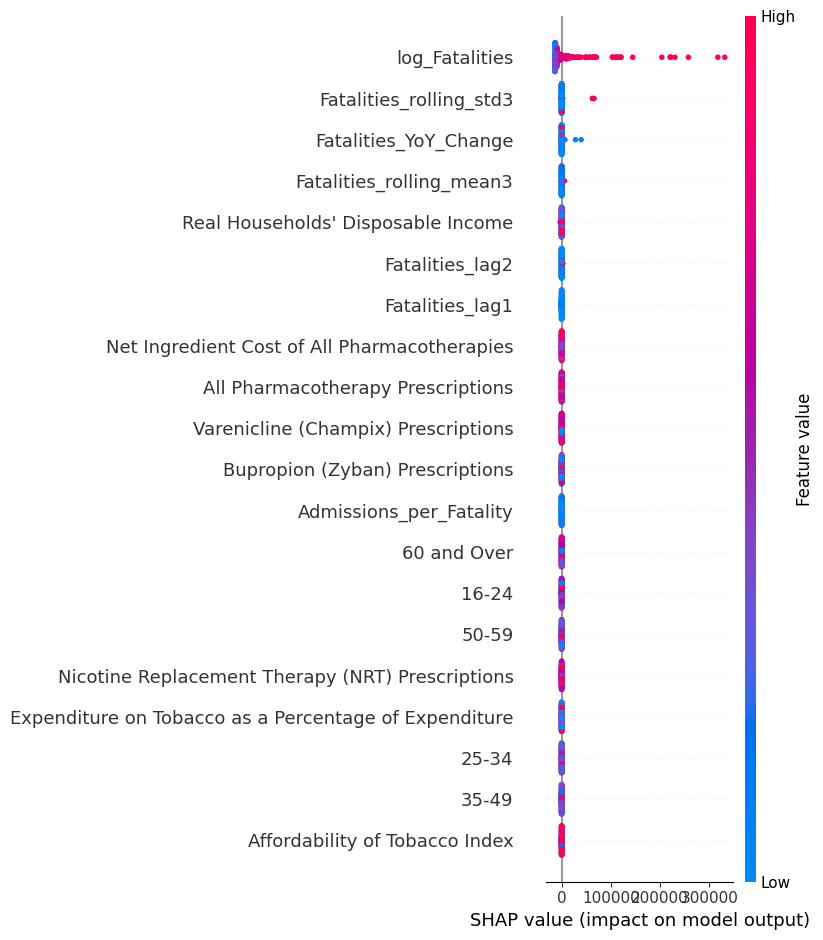

<Figure size 640x480 with 0 Axes>

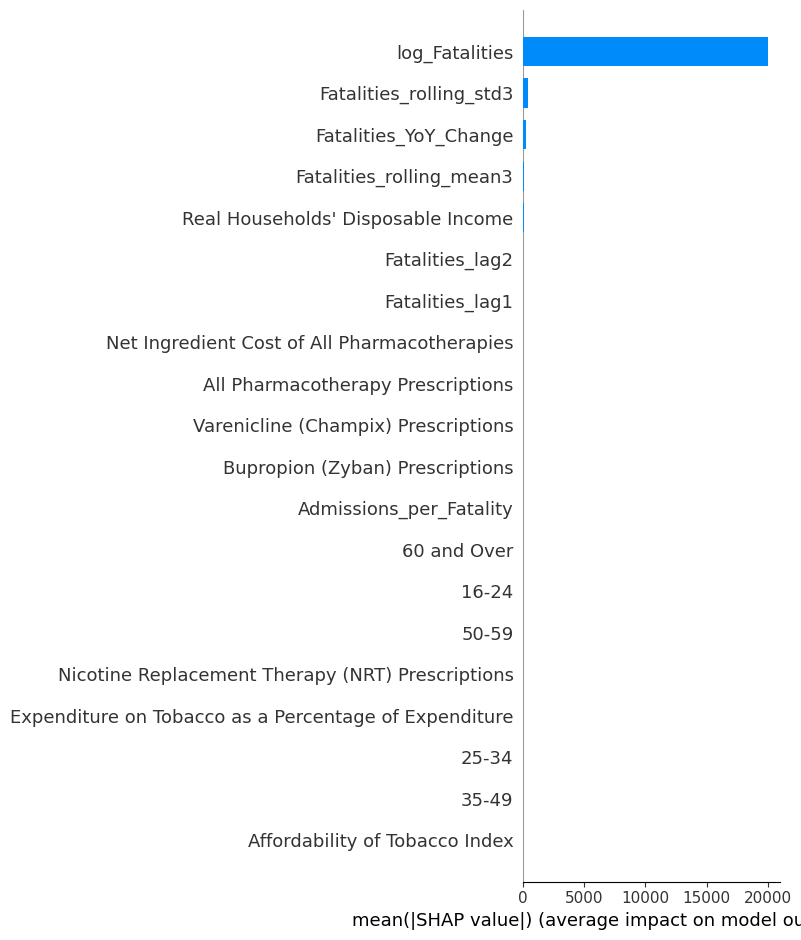

<Figure size 640x480 with 0 Axes>

In [69]:
# plots
plt.figure(figsize=(10,6))
shap.summary_plot(shap_exp, features=shap_exp.data, feature_names=X_test.columns.tolist())
plt.tight_layout()

plt.figure(figsize=(10,6))
shap.summary_plot(shap_exp, features=shap_exp.data, feature_names=X_test.columns.tolist(), plot_type="bar")
plt.tight_layout()

Deployment

In [70]:
# ---------- Configuration ----------
# Paths (change via environment if needed)
MODEL_DIR = os.environ.get("MODEL_DIR", "models")
PIPELINE_GB = os.path.join(MODEL_DIR, "gb_best_pipeline.joblib")
PIPELINE_RF = os.path.join(MODEL_DIR, "rf_best_pipeline.joblib")
PIPELINE_GENERIC = os.path.join(MODEL_DIR, "pipeline_best.joblib")
BACKGROUND_PATH_JOBLIB = os.path.join(MODEL_DIR, "X_bg_raw.joblib")
BACKGROUND_PATH_CSV = os.path.join(MODEL_DIR, "X_bg_raw.csv")

# Server port
PORT = int(os.environ.get("PORT", 5000))

In [71]:
# ---------- App & logging ----------
app = Flask(__name__)
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(name)s: %(message)s")
logger = logging.getLogger("tobacco_mortality_inference")

In [72]:
# ---------- Utilities ----------
def list_available_pipelines(model_dir: str) -> Dict[str, str]:
    """Return a mapping name->path for pipelines we consider relevant."""
    out = {}
    if os.path.exists(PIPELINE_GB):
        out["GB_tuned"] = PIPELINE_GB
    if os.path.exists(PIPELINE_RF):
        out["RF_tuned"] = PIPELINE_RF
    if os.path.exists(PIPELINE_GENERIC):
        out["pipeline_best"] = PIPELINE_GENERIC
    # also include any explicit joblib files in models dir
    for f in os.listdir(model_dir) if os.path.exists(model_dir) else []:
        if f.endswith(".joblib") and f not in (os.path.basename(PIPELINE_GB), os.path.basename(PIPELINE_RF), os.path.basename(PIPELINE_GENERIC)):
            out[f.replace(".joblib","")] = os.path.join(model_dir, f)
    return out

def load_joblib(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    logger.info("Loading joblib from %s", path)
    return joblib.load(path)

def try_load_background() -> Optional[pd.DataFrame]:
    if os.path.exists(BACKGROUND_PATH_JOBLIB):
        bg = joblib.load(BACKGROUND_PATH_JOBLIB)
        if isinstance(bg, pd.DataFrame):
            return bg
    if os.path.exists(BACKGROUND_PATH_CSV):
        return pd.read_csv(BACKGROUND_PATH_CSV)
    return None

def infer_feature_order_from_pipeline(pipeline) -> List[str]:
    """
    Try multiple heuristics to obtain feature names the pipeline expects.
    Order of attempts:
      1) pipeline.feature_names_in_ (sklearn >=1.0 attributes)
      2) pipeline.named_steps['preprocessor'].get_feature_names_out(input_features)
      3) pipeline.named_steps['scaler'].feature_names_in_ or similar
      4) pipeline.named_steps.get('model').feature_names_in_ or coef_ attribute names
      5) fallback to env var or DEFAULT_FEATURE_ORDER
    """
    try:
        # 1) direct attribute
        if hasattr(pipeline, "feature_names_in_"):
            return list(getattr(pipeline, "feature_names_in_"))
    except Exception:
        pass

    try:
        steps = getattr(pipeline, "named_steps", {})
        pre = steps.get("preprocessor") or steps.get("pre_proc") or steps.get("pre")
        if pre is not None and hasattr(pre, "get_feature_names_out"):
            # try to get input feature names from env if available
            if FEATURE_ORDER_ENV:
                in_feats = [s.strip() for s in FEATURE_ORDER_ENV.split(",")]
            else:
                # unknown input names -> can't call get_feature_names_out without input_features param,
                # but many ColumnTransformers implement it without arguments after fit
                in_feats = None
            try:
                if in_feats:
                    return list(pre.get_feature_names_out(in_feats))
                else:
                    return list(pre.get_feature_names_out())
            except Exception:
                # fallthrough
                pass
        # 2) scaler or model may have feature_names_in_
        scaler = steps.get("scaler")
        if scaler is not None and hasattr(scaler, "feature_names_in_"):
            return list(getattr(scaler, "feature_names_in_"))
        model = steps.get("model") or steps.get("clf") or getattr(pipeline, "estimators_", None)
        if model is not None:
            if hasattr(model, "feature_names_in_"):
                return list(getattr(model, "feature_names_in_"))
            # if coefficients exist, we cannot know names — skip
    except Exception:
        logger.debug("Feature inference heuristics failed", exc_info=True)

    # fallback to env var
    if FEATURE_ORDER_ENV:
        return [s.strip() for s in FEATURE_ORDER_ENV.split(",")]

    # final fallback default
    return DEFAULT_FEATURE_ORDER

def fig_to_base64_png(fig) -> str:
    buf = io.BytesIO()
    fig.savefig(buf, bbox_inches="tight")
    plt.close(fig)
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("ascii")

In [73]:
# ---------- Model loading & state ----------
PIPELINES = list_available_pipelines(MODEL_DIR)  # names->paths
ACTIVE_MODEL_NAME = None
ACTIVE_PIPELINE = None
FEATURE_ORDER = None
SHAP_BG = None

def set_active_pipeline(name: str) -> None:
    global ACTIVE_MODEL_NAME, ACTIVE_PIPELINE, FEATURE_ORDER, SHAP_BG
    if name not in PIPELINES:
        raise FileNotFoundError(f"No pipeline named '{name}' available. Available: {list(PIPELINES.keys())}")
    path = PIPELINES[name]
    pipe = load_joblib(path)
    # infer feature order (best effort)
    feat_order = infer_feature_order_from_pipeline(pipe)
    # load background lazily if available
    bg = try_load_background()
    ACTIVE_MODEL_NAME = name
    ACTIVE_PIPELINE = pipe
    FEATURE_ORDER = feat_order
    SHAP_BG = bg
    logger.info("Active model set to %s (path=%s). Inferred %d features.", name, path, len(feat_order))

# On startup pick best available model: prefer GB_tuned, then RF_tuned, then pipeline_best
if "GB_tuned" in PIPELINES:
    try:
        set_active_pipeline("GB_tuned")
    except Exception:
        logger.exception("Failed to load gb_best_pipeline at startup")
elif "RF_tuned" in PIPELINES:
    try:
        set_active_pipeline("RF_tuned")
    except Exception:
        logger.exception("Failed to load RF_tuned at startup")
elif "pipeline_best" in PIPELINES:
    try:
        set_active_pipeline("pipeline_best")
    except Exception:
        logger.exception("Failed to load pipeline_best at startup")
else:
    logger.warning("No pipeline found at startup. Endpoints will return 503 until a pipeline is added to %s", MODEL_DIR)

# Log diagnostic info
logger.info("cwd=%s", os.getcwd())
logger.info("MODEL_DIR=%s exists=%s", MODEL_DIR, os.path.exists(MODEL_DIR))
logger.info("Detected pipelines: %s", PIPELINES)
logger.info("Active model: %s", ACTIVE_MODEL_NAME)
logger.info("Background available: %s", SHAP_BG is not None)

2025-11-13 17:21:56,373 INFO tobacco_mortality_inference: Loading joblib from models/gb_best_pipeline.joblib
2025-11-13 17:21:56,387 INFO tobacco_mortality_inference: Active model set to GB_tuned (path=models/gb_best_pipeline.joblib). Inferred 27 features.
2025-11-13 17:21:56,387 INFO tobacco_mortality_inference: cwd=/Users/yashikasharma/Downloads/Projects/tobacco_use
2025-11-13 17:21:56,387 INFO tobacco_mortality_inference: MODEL_DIR=models exists=True
2025-11-13 17:21:56,388 INFO tobacco_mortality_inference: Detected pipelines: {'GB_tuned': 'models/gb_best_pipeline.joblib', 'RF_tuned': 'models/rf_best_pipeline.joblib', 'X_bg_raw': 'models/X_bg_raw.joblib', 'logistic_pipeline': 'models/logistic_pipeline.joblib', 'logistic_best_pipeline': 'models/logistic_best_pipeline.joblib'}
2025-11-13 17:21:56,388 INFO tobacco_mortality_inference: Active model: GB_tuned
2025-11-13 17:21:56,389 INFO tobacco_mortality_inference: Background available: True


In [74]:
# ---------- Input validation & conversion ----------
def validate_single_record(data: Dict[str, Any]) -> Dict[str, Any]:
    if not isinstance(data, dict):
        raise BadRequest("Single record must be a JSON object (dictionary).")
    if FEATURE_ORDER is None:
        raise BadRequest("Feature order not configured on server.")
    missing = [f for f in FEATURE_ORDER if f not in data]
    if missing:
        raise BadRequest(f"Missing required features: {missing}")
    return data

def record_dict_to_df(record: Dict[str, Any]) -> pd.DataFrame:
    """Return a DataFrame with columns in FEATURE_ORDER, types casted to numeric where possible."""
    row = {}
    for feat in FEATURE_ORDER:
        v = record.get(feat)
        # try numeric cast, but keep category strings if cast fails
        if v is None:
            row[feat] = np.nan
        else:
            try:
                row[feat] = float(v)
            except Exception:
                row[feat] = v
    return pd.DataFrame([row], columns=FEATURE_ORDER)

In [75]:
# ---------- Routes ----------
@app.route("/", methods=["GET"])
def index():
    return jsonify({
        "service": "tobacco_mortality_inference",
        "active_model": ACTIVE_MODEL_NAME,
        "available_models": list(PIPELINES.keys()),
        "feature_count": len(FEATURE_ORDER) if FEATURE_ORDER else None,
    })

@app.route("/health", methods=["GET"])
def health():
    healthy = ACTIVE_PIPELINE is not None
    return jsonify({"healthy": healthy, "active_model": ACTIVE_MODEL_NAME})

@app.route("/models", methods=["GET"])
def models_list():
    return jsonify({
        "available": list(PIPELINES.keys()),
        "active": ACTIVE_MODEL_NAME
    })

@app.route("/models/select", methods=["POST"])
def models_select():
    """
    Body: {"model": "<name>"}
    Example names: "GB_tuned", "RF_tuned", "pipeline_best", or other joblib base names present in models/
    """
    body = request.get_json(force=True)
    name = body.get("model")
    if not name:
        return jsonify({"error": "Provide 'model' in JSON body"}), 400
    try:
        set_active_pipeline(name)
        return jsonify({"status": "ok", "active": ACTIVE_MODEL_NAME}), 200
    except FileNotFoundError as e:
        return jsonify({"error": str(e)}), 404
    except Exception:
        logger.exception("Selecting model failed")
        return jsonify({"error": "Internal server error"}), 500

@app.route("/predict", methods=["POST"])
def predict():
    """
    Accepts either:
      - a single JSON object: {"feat1":..., "feat2":..., ...}
      - or an array of such objects for batch: [{...}, {...}]
    Returns:
      - predictions: list of ints/floats (or single value if single record)
      - optionally probabilities if pipeline provides predict_proba
    """
    if ACTIVE_PIPELINE is None:
        return jsonify({"error": "No active pipeline loaded on server."}), 503

    try:
        body = request.get_json(force=True)
    except BadRequest:
        return jsonify({"error": "Invalid JSON payload."}), 400

    try:
        if isinstance(body, list):
            # batch
            dfs = []
            for rec in body:
                validate_single_record(rec)
                dfs.append(record_dict_to_df(rec))
            X = pd.concat(dfs, ignore_index=True)
        elif isinstance(body, dict):
            validate_single_record(body)
            X = record_dict_to_df(body)
        else:
            return jsonify({"error": "Payload must be a JSON object or an array of objects."}), 400

        # pipeline.predict should accept a DataFrame (common pattern)
        preds = ACTIVE_PIPELINE.predict(X)
        preds_list = np.asarray(preds).tolist()

        out = {"predictions": preds_list}
        # optionally add probabilities when available (e.g., classifier)
        if hasattr(ACTIVE_PIPELINE, "predict_proba"):
            try:
                prob = ACTIVE_PIPELINE.predict_proba(X).tolist()
                out["probabilities"] = prob
            except Exception:
                # some pipelines don't implement predict_proba; ignore
                pass

        # if single dict input, return single prediction not list
        if isinstance(body, dict):
            # convert to native types
            return jsonify({"prediction": out["predictions"][0], **({"probabilities": out.get("probabilities")[0]} if "probabilities" in out else {})})
        return jsonify(out)
    except BadRequest as e:
        return jsonify({"error": str(e)}), 400
    except Exception:
        logger.error("Prediction failed: %s", traceback.format_exc())
        return jsonify({"error": "Internal server error"}), 500

@app.route("/interpret", methods=["POST"])
def interpret():
    """
    Returns SHAP values and a base64 waterfall plot for a single record.
    Requires background data (X_bg_raw.joblib or X_bg_raw.csv) to exist on server; otherwise 503.
    """
    if ACTIVE_PIPELINE is None:
        return jsonify({"error": "No active pipeline loaded on server."}), 503
    if SHAP_BG is None:
        return jsonify({"error": "SHAP background data not available on server."}), 503

    try:
        body = request.get_json(force=True)
    except BadRequest:
        return jsonify({"error": "Invalid JSON payload."}), 400

    if not isinstance(body, dict):
        return jsonify({"error": "Interpret endpoint accepts a single JSON object (one record)."}), 400

    try:
        validate_single_record(body)
        X = record_dict_to_df(body)

        # Build explainer using pipeline.predict as callable
        explainer = shap.Explainer(ACTIVE_PIPELINE.predict, SHAP_BG)
        shap_exp = explainer(X)  # Explanation for single-row DataFrame

        # shap_exp.values shape typically (1, n_features)
        vals = np.asarray(shap_exp.values)
        # try to squeeze to (n_features,)
        try:
            arr = vals.reshape(vals.shape[-1],) if vals.ndim == 1 else vals.squeeze()[0]
        except Exception:
            arr = vals.squeeze()
            if arr.ndim > 1:
                arr = arr[0]

        # feature names
        feature_names = list(shap_exp.feature_names) if shap_exp.feature_names is not None else FEATURE_ORDER
        shap_pairs = [{"feature": f, "shap_value": float(v)} for f, v in zip(feature_names, arr)]

        # waterfall (or fallback horizontal bar)
        try:
            shap_fig = plt.figure(figsize=(8,4))
            shap.plots.waterfall(shap_exp[0], show=False)
            shap_fig = plt.gcf()
        except Exception:
            # fallback
            abs_vals = np.abs(arr)
            order = np.argsort(-abs_vals)
            feat_ordered = [feature_names[i] for i in order]
            vals_ordered = arr[order]
            fig, ax = plt.subplots(figsize=(8,4))
            ax.barh(feat_ordered, vals_ordered)
            ax.set_xlabel("SHAP value")
            ax.set_title("SHAP contributions (fallback)")
            plt.tight_layout()
            shap_fig = fig

        png_b64 = fig_to_base64_png(shap_fig)
        # numeric prediction
        pred = ACTIVE_PIPELINE.predict(X)
        prediction = np.asarray(pred)[0]

        return jsonify({
            "prediction": prediction,
            "shap_values": shap_pairs,
            "plot_png_base64": png_b64
        }), 200

    except BadRequest as e:
        return jsonify({"error": str(e)}), 400
    except Exception:
        logger.error("Interpretation failed: %s", traceback.format_exc())
        return jsonify({"error": "Internal server error"}), 500

In [76]:
# ---------- Run ----------
if __name__ == "__main__":
    app.run(host="0.0.0.0", port=PORT, debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


2025-11-13 17:22:02,202 INFO werkzeug: WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.29.38:5000
2025-11-13 17:22:02,204 INFO werkzeug: Press CTRL+C to quit
